🇭 🇪 🇱 🇱 🇴 👋

This example shows how to use `segmentation-models-pytorch` for **binary** semantic segmentation. We will use the [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (this is an adopted example from Albumentations package [docs](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/), which is strongly recommended to read, especially if you never used this package for augmentations before).

The task will be to classify each pixel of an input image either as pet 🐶🐱 or as a background.


What we are going to overview in this example:  

 - 📜 `Datasets` and `DataLoaders` preparation (with predefined dataset class).  
 - 📦 `LightningModule` preparation: defining training, validation and test routines.  
 - 📈 Writing `IoU` metric inside the `LightningModule` for measuring quality of segmentation.  
 - 🐶 Results visualization.


> It is expected you are familiar with Python, PyTorch and have some experience with training neural networks before!

In [ ]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning==1.9.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=abf804a962323cb0af6d2482a9daff1da4b5783c5a53d239b127d53751827361
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=f7e3bdb32b236876658b44293323539eb86f08191eff21062224046a3b0d9adc
  Stored in directory: /root/.cache/pip/w

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import numpy as np
from tqdm import tqdm
from PIL import Image
from pprint import pprint
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import random
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

## Dataset

In this example we will use predefined `Dataset` class for simplicity. The dataset actually read pairs of images and masks from disk and return `sample` - dictionary with keys `image`, `mask` and others (not relevant for this example).

⚠️ **Dataset preparation checklist** ⚠️

In case you writing your own dataset, please, make sure that:

1.   **Images** 🖼  
    ✅   Images from dataset have **the same size**, required for packing images to a batch.  
    ✅   Images height and width are **divisible by 32**. This step is important for segmentation, because almost all models have skip-connections between encoder and decoder and all encoders have 5 downsampling stages (2 ^ 5 = 32). Very likely you will face with error when model will try to concatenate encoder and decoder features if height or width is not divisible by 32.  
    ✅   Images have **correct axes order**. PyTorch works with CHW order, we read images in HWC [height, width, channels], don`t forget to transpose image.
2.   **Masks** 🔳  
    ✅   Masks have **the same sizes** as images.   
    ✅   Masks have only `0` - background and `1` - target class values (for binary segmentation).  
    ✅   Even if mask don`t have channels, you need it. Convert each mask from **HW to 1HW** format for binary segmentation (expand the first dimension).

Some of these checks are included in LightningModule below during the training.

❗️ And the main rule: your train, validation and test sets are not intersects with each other!

In [ ]:
# from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [ ]:
# # download data
# root = "."
# SimpleOxfordPetDataset.download(root)

In [ ]:

class CVCDataset(torch.utils.data.Dataset):
    def __init__(self,root, filenames_before, mode="train", transform=None):

        assert mode in {"train", "valid", "test"}

        self.root = root
        self.filenames_before=filenames_before
        self.mode = mode
        self.transform = transform

        self.images_directory = os.path.join(self.root, "images")
        self.masks_directory = os.path.join(self.root, "annotations")

        self.filenames = self._read_split()  # read train/valid/test splits

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):

        filename = self.filenames[idx]
        # image_path = os.path.join(self.images_directory, filename ) # path to images
        # mask_path = os.path.join(self.masks_directory, filename )   # path to annotations

        image_path = os.path.join(self.images_directory, filename + ".png") # path to images
        mask_path = os.path.join(self.masks_directory, filename + ".png")   # path to annotations

        # trimap = np.array(Image.open(mask_path))
        # mask = self._preprocess_mask(trimap)
        # sample = dict(image=image, mask=mask, trimap=trimap)

        temp_img = Image.open(image_path).convert("RGB")
        image = F.adjust_brightness(temp_img, 1.05)

        image = np.array(image)
        mask = np.array(Image.open(mask_path).convert("L"))
        # mask = np.array(Image.open(mask_path).convert("RGB"))/255



        # mask = Image.open(mask_path)

        sample = dict(image=image, mask=mask)
        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    @staticmethod
    def _preprocess_mask(mask):
        mask = mask.astype(np.float32)
        mask[mask == 2.0] = 0.0
        mask[(mask == 1.0) | (mask == 3.0)] = 1.0
        return mask

    def _read_split(self):

        # folder_name=self.root+'images'
        filenames_before=self.filenames_before
        print("before",filenames_before.__len__())

        if self.mode == "train":  # 80% for train
            filenames_splitted =filenames_before[:int(0.8*filenames_before.__len__())]
        elif self.mode == "valid":  # 10% for validation
            filenames_splitted = filenames_before[int(0.8*filenames_before.__len__()):int(0.9*filenames_before.__len__())]
        elif self.mode == "test":  # 10% for test
            filenames_splitted = filenames_before[int(0.9*filenames_before.__len__()):]

        print("files",self.mode,int(filenames_splitted.__len__()))
        # filenames = [x.split(".")[0] for x in filenames]

         # def oxford_split(self):
        #     split_filename = "test.txt" if self.mode == "test" else "trainval.txt"
        #     split_filepath = os.path.join(self.root, "annotations", split_filename)     # Truth text files from -> annotations/test.txt or annotations/trainval.txt
        #     with open(split_filepath) as f:
        #         split_data = f.read().strip("\n").split("\n")
        #     filenames = [x.split(" ")[0] for x in split_data]

        #     # Splitting the train-validations
        #     if self.mode == "train":  # 90% for train
        #         filenames = [x for i, x in enumerate(filenames) if i % 10 != 0]
        #     elif self.mode == "valid":  # 10% for validation
        #         filenames = [x for i, x in enumerate(filenames) if i % 10 == 0]


        """
        TODOS
            1. Extract all image names in self.root directory (e.g. they have Abyssinian_100.png as the image, the filenames are like Abyssinian_100 without extensions)
            2. Shuffle the images (Optional but recommended)
            3. Allocate favorable portions to train-val-test. They have (3312, 368, 3669) for (train, val, test) from the same 7393 images, all disjoint
            note : get all the names from the image directory. Then use this way:
                    1. root + 'image' + 'img_name' for image
                    2. root + 'annotation'+'img_name' for annotation

            ** just refer to their test.txt and trainval.txt for any clarification or how they used the names
            ** their split and extractions are commented below if needed
        """


        """.....DO THE TODOS HERE...."""

        return filenames_splitted


class SimpleCVCDataset(CVCDataset):
    def __getitem__(self, *args, **kwargs):

        sample = super().__getitem__(*args, **kwargs)

        # resize images
        image = np.array(Image.fromarray(sample["image"]).resize((256, 256), Image.LINEAR))
        mask = np.array(Image.fromarray(sample["mask"]).resize((256, 256), Image.NEAREST))
        # trimap = np.array(Image.fromarray(sample["trimap"]).resize((256, 256), Image.NEAREST))

        # convert to other format HWC -> CHW
        sample["image"] = np.moveaxis(image, -1, 0)
        sample["mask"] = np.expand_dims(mask, 0)
        # sample["trimap"] = np.expand_dims(trimap, 0)

        return sample

class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)



In [ ]:

def cvc_data_handler():
    # root = "Binary Segmentation_Cats"   # *change the root directory
    root = "/content/drive/MyDrive/4-2/ML project/CVC-dataset/PNG/"

    # shuffle the contents

    folder_name=root+'images'
    filenames=os.listdir(folder_name)
    filenames = [x.split(".")[0] for x in filenames]


    random.shuffle(filenames)

    # transform_train=transforms.Compose([
    # transforms.RandomVerticalFlip(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(30),
    # transforms.RandomChoice([
    # transforms.Pad(padding=10, padding_mode='reflect'),
    # transforms.CenterCrop(480),
    # transforms.RandomRotation(20),
    # transforms.CenterCrop((576,432)),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # ]),
    # transforms.Resize((256,256)),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # ])

    # transform_train=transforms.Compose([
    #     transforms.ToPILImage(),
    #     transforms.RandomHorizontalFlip(),
    #     transforms.RandomVerticalFlip(),
    #     transforms.RandomRotation(90),
    #     transforms.ToTensor(),
    # ])


    transform_train = None


    # init train, val, test sets
    train_dataset = SimpleCVCDataset(root,filenames, "train",transform=transform_train)
    valid_dataset = SimpleCVCDataset(root,filenames, "valid",transform=transform_train)
    test_dataset = SimpleCVCDataset(root,filenames, "test",transform=transform_train)

    # print("train_dataset = {}".format(train_dataset.filenames))
    # print("train_dataset = {}".format(len(train_dataset.filenames)))
    # print("valid_dataset = {}".format(len(valid_dataset.filenames)))
    # print("test_dataset = {}".format(len(test_dataset.filenames)))




    # It is a good practice to check datasets don`t intersects with each other
    assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
    assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
    assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

    print(f"Train size: {len(train_dataset)}")
    print(f"Valid size: {len(valid_dataset)}")
    print(f"Test size: {len(test_dataset)}")

    n_cpu = os.cpu_count()
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
    valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

    return train_dataloader, valid_dataloader, test_dataloader

train_dataloader, valid_dataloader, test_dataloader = cvc_data_handler()


before 612
files train 489
before 612
files valid 61
before 612
files test 62
Train size: 489
Valid size: 61
Test size: 62


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # # init train, val, test sets
# root = '.'
# train_dataset = SimpleOxfordPetDataset(root, "train")
# valid_dataset = SimpleOxfordPetDataset(root, "valid")
# test_dataset = SimpleOxfordPetDataset(root, "test")

# # It is a good practice to check datasets don`t intersects with each other
# assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
# assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
# assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

# print(f"Train size: {len(train_dataset)}")
# print(f"Valid size: {len(valid_dataset)}")
# print(f"Test size: {len(test_dataset)}")

# n_cpu = os.cpu_count()
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
# valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
# test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

# print(type(train_dataset))
# sample = train_dataset[0]
# print(type(sample))
# print(sample)

In [ ]:
# # for getting access to train_dataset , portion of code from  cvc_data_handler() is  extracted out here below
# root = "/content/drive/MyDrive/4-2/ML project/CVC-dataset/PNG/"

# # init train, val, test sets
# train_dataset = SimpleCVCDataset(root, "train")
# valid_dataset = SimpleCVCDataset(root, "valid")
# test_dataset = SimpleCVCDataset(root, "test")

# # print("train_dataset = {}".format(train_dataset.filenames))
# # print("train_dataset = {}".format(len(train_dataset.filenames)))
# # print("test_dataset = {}".format(len(valid_dataset.filenames)))
# # print("test_dataset = {}".format(len(test_dataset.filenames)))

# # It is a good practice to check datasets don`t intersects with each other
# assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
# assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
# assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

# # print(f"Train size: {len(train_dataset)}")
# # print(f"Valid size: {len(valid_dataset)}")
# # print(f"Test size: {len(test_dataset)}")

# n_cpu = os.cpu_count()
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
# valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
# test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

# print(len(train_dataset))

In [ ]:
# print(type(train_dataset))
# sample = train_dataset.__getitem__(0)
# print(sum(sum(sum((sample["mask"]<255)>0))))


# plt.subplot(1,2,1)
# plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
# plt.subplot(1,2,2)
# plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
# plt.show()


In [ ]:
# # # lets look at some samples

# sample = train_dataset[0]
# plt.subplot(1,2,1)
# plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
# plt.subplot(1,2,2)
# plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
# plt.show()

# sample = valid_dataset[0]
# plt.subplot(1,2,1)
# plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
# plt.subplot(1,2,2)
# plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
# plt.show()

# sample = test_dataset[0]
# plt.subplot(1,2,1)
# plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
# plt.subplot(1,2,2)
# plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
# plt.show()

## Model

In [ ]:
class PetModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        # print("mask shape", mask.shape)
        # mask=mask.reshape((mask.shape[0],1,mask.shape[2],mask.shape[3]))
        # mask=mask.permute(0,3,1,2)
        # print("mask shape", mask.shape)
        # print("image shape", image.shape)
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        mask=mask/255
        assert mask.max() <= 1.0 and mask.min() >= 0
        # print("mask val passed")

        logits_mask = self.forward(image)
        # print("forward done")
        # print("logits_mask",logits_mask.shape)
        # print("mask",mask.shape)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        # print("prob_mask in")
        prob_mask = logits_mask.sigmoid()
        # print("pred_mask in")

        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        # print("shared step done")
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0005)

## Training

In [ ]:
model = PetModel("FPN", "resnet34", in_channels=3, out_classes=1)
trainer = pl.Trainer(
    gpus=1,
    max_epochs=10,
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total pa

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## Validation and test metrics

In [ ]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.8741048574447632,
  'valid_per_image_iou': 0.8499171733856201}]


In [ ]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 0.8335800766944885,
  'test_per_image_iou': 0.8133648633956909}]


# Result visualization

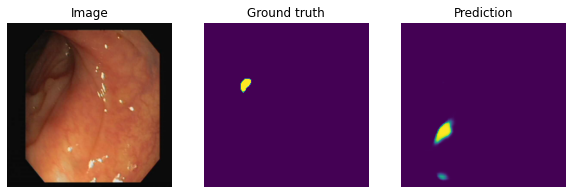

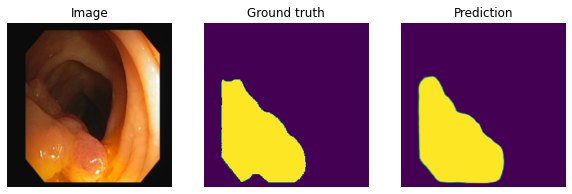

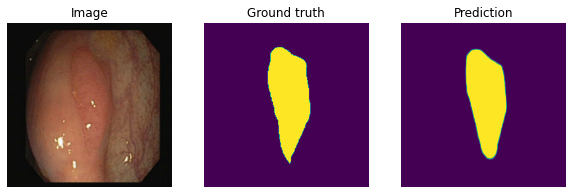

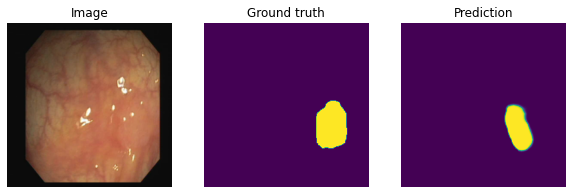

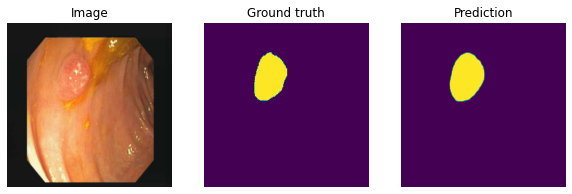

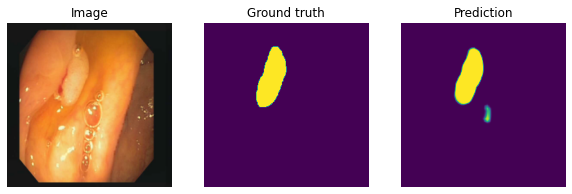

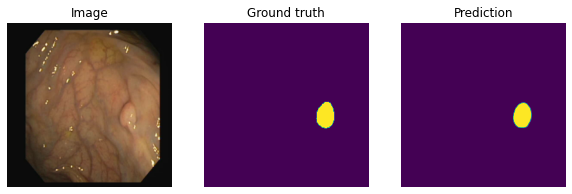

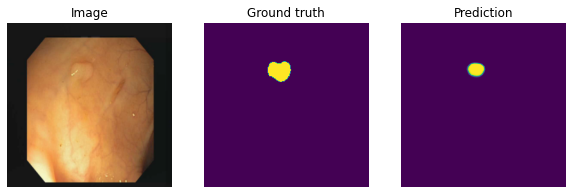

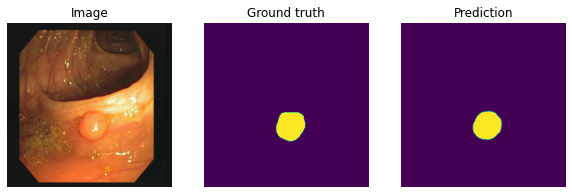

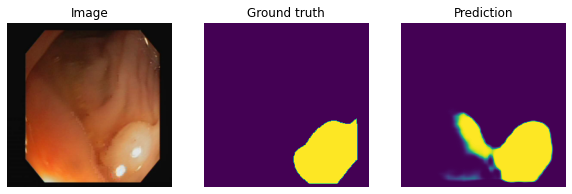

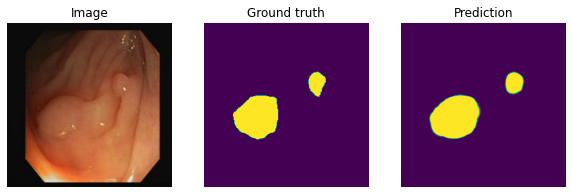

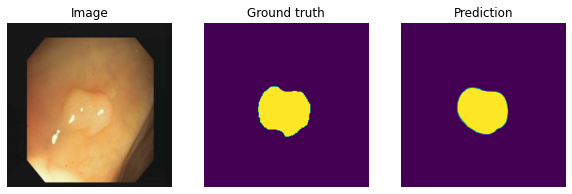

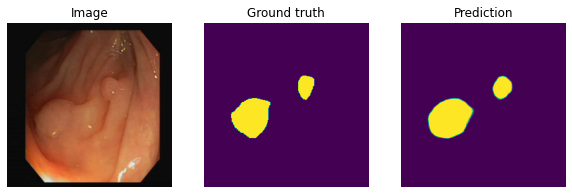

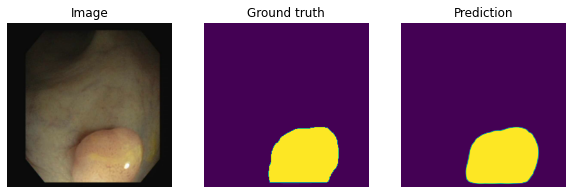

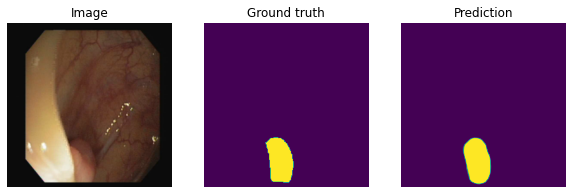

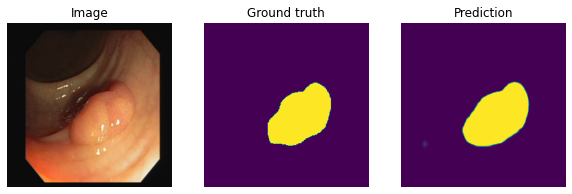

In [ ]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()